## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import os.path
from os import path
from collections import OrderedDict
import time

models_dir = os.path.expanduser('~/group/donut/medical_ip/trained_models')
model_name = 'model_resenet18_multi_class_multi_label.pt'
model_path = os.path.join(models_dir, model_name)
print('Model save/load location: {}'.format(model_path))

Model save/load location: /home/tu-weihengxia/group/donut/medical_ip/trained_models/model_resenet18_multi_class_multi_label.pt


## Custom Dataset Loading Class

In [2]:
label_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation',
              'Infiltration','Fibrosis','Pneumonia','No Finding']

In [3]:
def resolve_full_path(img_name):
    is_found = False

    # Read 1 image file
    folder_idx_range = 13
    img_path = ''
    for folder_idx in range(folder_idx_range):
        path_prefix = path.expanduser("~/data/kaggle/nih-chest-xrays/data/images_")
        path_suffix = "images/"
        cur_img_dir = path_prefix +str(folder_idx).zfill(3) +'/'
        img_folder_path = path.join(cur_img_dir, path_suffix)
        img_path = os.path.join(img_folder_path, img_name)

        if(path.exists(img_path)):
            is_found = True
            break
    if(not is_found):
        
        raise Exception('Couldn\'t find: {} last:{}'.format(img_name, img_path))
    return img_path
        
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.data_len = len(self.data.index)            # csv data length
        
        self.image_names = np.array(self.data.iloc[:,0])  # image names
        self.heights = np.asarray(self.data.iloc[:,8])    # heights are at 8th column 
        self.widths =  np.asarray(self.data.iloc[:,7])    # widths are at  7th column
        
        # createa a tensor to store labels
        self.labels = torch.zeros(self.data_len, 15)
        labels = self.data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
        self.multi_hot_encoding_label(labels)
    
        self.transform = transform
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        # Read 1 image name
        img_name = self.image_names[index]
        img_path = resolve_full_path(img_name)
        img_as_img = Image.open(img_path)

        img_as_img = img_as_img.convert("RGB")
        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)

        # Read 1 label:
        image_label = self.labels[index]

        return img_as_tensor, image_label
    
    def multi_hot_encoding_label(self, labels):
            for i,label in enumerate(labels):
                for idx in range(len(label_list)):
                    if label_list[idx] in label:
                        self.labels[i][idx] = 1

## Resample imbalanced dataset

In [4]:
# Iterate through all_labels to calculate each case's weight
def calculate_weight(data):
    D_single_weight = calculate_single_label_weight(data)
    weight = torch.zeros(data.shape[0])
    
    all_labels = data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    for i, labels in enumerate(all_labels):
        for ii, label in enumerate(labels):
            weight[i] += D_single_weight[label]
    
    return weight

def calculate_single_label_weight(data):
    # Calculate single label weight
    D_sorted = count_label(data)
    D_single_weight = D_sorted.copy()
    for i, label in enumerate(D_single_weight.keys()):
        D_single_weight[label] = 1.0/D_single_weight[label]*1e5
        
    return D_single_weight

def count_label(data):
    D_label_count = dict()
    all_labels = data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    for i,labels in enumerate(all_labels):
        for ii, label in enumerate(labels):
            D_label_count[label] = D_label_count.get(label, 0) + 1
    D = D_label_count
    D_sorted = OrderedDict(sorted(D.items(), key=lambda x: x[1], reverse=True))
    
    return D_sorted

## Use dataloader to load data

In [5]:
# Define transforms
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define custom data loader
train_dataset = DatasetFromCSV('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/traindata_paul.csv',transform=transform)
valid_dataset = DatasetFromCSV('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/valdata_paul.csv',transform=transform)
batch_size_ = 10

# Define sampler to resample the imbalanced dataset
train_dataset_entry = pd.read_csv("~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/traindata_paul.csv")
sample_weight = calculate_weight(train_dataset_entry)
print("sample weights shape: ", sample_weight.shape)
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weight, batch_size_)


print("training dataset len:", len(train_dataset))
print("testing dataset len:", len(valid_dataset))

# Define two data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=True)

print("train_loader len: ", len(train_loader))
print("test_loader len: ", len(valid_loader))

sample weights shape:  torch.Size([78534])
training dataset len: 78534
testing dataset len: 11056
train_loader len:  7854
test_loader len:  1106


## Show the loaded images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image batch shape:  torch.Size([10, 3, 224, 224])
single image shape:  torch.Size([3, 224, 224])
img_1channel shape:  (224, 224)
img_3channel shape: torch.Size([224, 224, 3])
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
label type: <class 'torch.Tensor'>


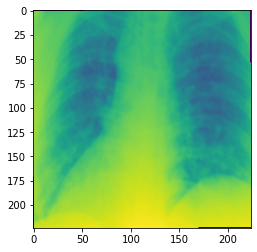

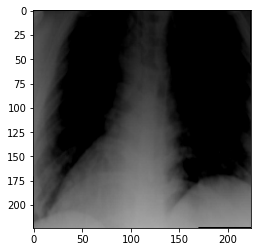

In [6]:
image, label = next(iter(train_loader))

print("\nimage batch shape: ", image.shape)
print("single image shape: ", image[9].shape)

# 1 channel image
img_1_channel = image.numpy()[9][1]
print("img_1channel shape: ", img_1_channel.shape)
plt.figure()
plt.imshow(img_1_channel)

# 3 channel image
plt.figure()
img_3_channel = image[9].permute(1, 2, 0)
plt.imshow(img_3_channel, cmap='cool')
print("img_3channel shape:", img_3_channel.shape)

# print label
print("labels:",label)
print("label type:",type(label))

In [7]:
# print label
image, label = next(iter(train_loader))

print("labels:",label)
print("label type:",type(label))

labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
label type: <class 'torch.Tensor'>


## Define the model with Transfer learning

In [8]:
from torchvision import models

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

def create_model():
    
    # Import pre-trained densenet-121
    model = models.resnet18(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    # Change output to classfiy 14 conditioins + nothing.
    # Change a new classifier
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 15)
    )
    return model
model = create_model()
print(model)

Using device:  cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

### Specify Loss function and Optimizer

In [9]:


criterion = nn.BCEWithLogitsLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.to(device);

## Train the model

In [10]:
from torch.autograd import Variable

# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    t0 = time.time()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):

        data = data.to(device)
        target = target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    t1 = time.time()
    total = t1-t0
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} Duration seconds: {}'.format(
        epoch, train_loss, valid_loss, total))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), model_path)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.215629 	Validation Loss: 0.210045 Duration seconds: 825.8917987346649
Validation loss decreased (inf --> 0.210045).  Saving model ...
Epoch: 2 	Training Loss: 0.213047 	Validation Loss: 0.208298 Duration seconds: 818.2555778026581
Validation loss decreased (0.210045 --> 0.208298).  Saving model ...
Epoch: 3 	Training Loss: 0.212234 	Validation Loss: 0.207177 Duration seconds: 769.6146385669708
Validation loss decreased (0.208298 --> 0.207177).  Saving model ...
Epoch: 4 	Training Loss: 0.211033 	Validation Loss: 0.208732 Duration seconds: 775.261402130127
Epoch: 5 	Training Loss: 0.210167 	Validation Loss: 0.206269 Duration seconds: 767.4130120277405
Validation loss decreased (0.207177 --> 0.206269).  Saving model ...
Epoch: 6 	Training Loss: 0.209721 	Validation Loss: 0.207063 Duration seconds: 783.4216599464417
Epoch: 7 	Training Loss: 0.209253 	Validation Loss: 0.207355 Duration seconds: 782.0601859092712
Epoch: 8 	Training Loss: 0.208932 	Validation Loss:

# Test classficaton on a single image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 15)
(10, 15)
Predicted: [-3.402565   -4.4141927  -1.6160924  -8.766507   -3.248878   -3.637563
 -1.6326284  -4.4083047  -3.8044329  -2.5923743  -2.7269533  -0.73718095
 -5.544187   -3.5627506  -0.5101659 ]
Predicted sigmoid: [3.2215398e-02 1.1959559e-02 1.6574447e-01 1.5584276e-04 3.7367225e-02
 2.5641605e-02 1.6347061e-01 1.2029336e-02 2.1786597e-02 6.9630809e-02
 6.1401512e-02 3.2362092e-01 3.8948911e-03 2.7578562e-02 3.7515464e-01]
Actual: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Max : -0.5101659297943115
Actual Max : 1.0
Predicted Sigmoid Arg Max : 0.9999991684719722
Actual Arg Max : 2
-0.5101659

image batch shape:  torch.Size([10, 3, 224, 224])
single image shape:  torch.Size([3, 224, 224])
img_1channel shape:  (224, 224)
img_3channel shape: torch.Size([224, 224, 3])
labels: tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

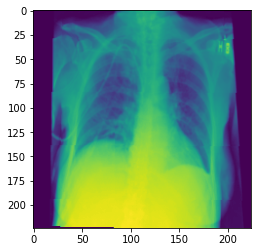

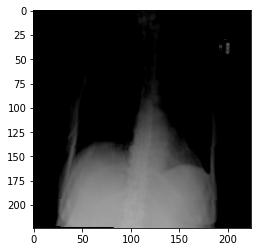

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# Doing inference on cpu as it doesn't take much effort feel free to change.
# Had some trouble loading it on GPU. 
image, label = next(iter(valid_loader))
model = create_model()
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

data = image.to('cpu')
# forward pass: compute predicted outputs by passing inputs to the model
output = model(data)
output = output.to('cpu').detach().numpy()
target = label.to('cpu').detach().numpy()
cur = 7
print(np.shape(target))
print(np.shape(output))

print("Predicted: {}".format(output[cur]))
print("Predicted sigmoid: {}".format(sigmoid(output[cur])))

print("Actual: {}".format(target[cur]))

print("Predicted Max : {}".format(output[cur].max()))
print("Actual Max : {}".format(target[cur].max()))

print("Predicted Sigmoid Arg Max : {}".format(sigmoid(output[cur].argmax())))
print("Actual Arg Max : {}".format(target[cur].argmax()))


print(output[cur].max())
print("\nimage batch shape: ", image.shape)
print("single image shape: ", image[cur].shape)




# 1 channel image
img_1_channel = image.numpy()[cur][1]
print("img_1channel shape: ", img_1_channel.shape)
plt.figure()
plt.imshow(img_1_channel)

# 3 channel image
plt.figure()
img_3_channel = image[cur].permute(1, 2, 0)
plt.imshow(img_3_channel, cmap='cool')
print("img_3channel shape:", img_3_channel.shape)

# print label
print("labels:",label)
